# **Install and Import Packages**

In [7]:
!pip install -q pandas numpy kagglehub google-generativeai

In [8]:
import pandas as pd
import numpy as np
import re
import unicodedata
import json
import time
import os
import kagglehub
import matplotlib.pyplot as plt

import google.generativeai as genai
from google.colab import userdata


# **CONFIGURE GEMINI API KEY**

In [9]:
GEMINI_API_KEY = userdata.get("GEMINI")
# or GEMINI_API_KEY = "YOUR_API_KEY"
genai.configure(api_key=GEMINI_API_KEY)

model = genai.GenerativeModel("gemini-2.5-flash")

In [10]:
def normalize_name(name):
    if pd.isna(name):
        return name

    name = unicodedata.normalize("NFKD", name)
    name = name.encode("ascii", "ignore").decode("utf-8")
    name = name.lower()
    name = re.sub(r"\(.*?\)", "", name)
    name = re.sub(r"[^\w\s]", "", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name


In [11]:
# LOAD DATASET AND SEPERATE IT ON THE BASIS OF region_type(State/UTs/City)

df = pd.read_csv("accidents.csv")
df['State/UT/City'] = df['State/UT/City'].apply(normalize_name)

total_idxs = df[df['State/UT/City'].str.contains("total", na=False)].index.tolist()

idx_state_total, idx_ut_total, idx_all_india_total, idx_city_total = total_idxs[:4]

states_df = df.iloc[:idx_state_total].copy()
uts_df    = df.iloc[idx_state_total+1:idx_ut_total].copy()
cities_df = df.iloc[idx_all_india_total+1:idx_city_total].copy()

def clean_totals(d):
    return d[~d['State/UT/City'].str.contains("total", na=False)].reset_index(drop=True)

states_df = clean_totals(states_df)
uts_df    = clean_totals(uts_df)
cities_df = clean_totals(cities_df)

states_df['region_type'] = 'State'
uts_df['region_type']    = 'UT'
cities_df['region_type'] = 'City'


# **LOAD THE DATASET WITH LATITUDE AND LONGITUDE**

In [12]:
path = kagglehub.dataset_download("danishxr/poptable")
state_latlong = pd.read_csv(f"{path}/poptable.csv")

state_latlong = state_latlong.rename(columns={
    'State.Name': 'name',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
})

state_latlong['name_norm'] = state_latlong['name'].apply(normalize_name)


100%|██████████| 998/998 [00:00<00:00, 1.27MB/s]

Extracting files...


In [13]:
path = kagglehub.dataset_download("arjunprasadsarkhel/indian-city-latitude-longitude")
city_latlong = pd.read_csv(f"{path}/India Cities LatLng.csv")

city_latlong = city_latlong.rename(columns={
    'city': 'name',
    'lat': 'Latitude',
    'lng': 'Longitude'
})

city_latlong['name_norm'] = city_latlong['name'].apply(normalize_name)


100%|██████████| 4.59k/4.59k [00:00<00:00, 12.5MB/s]

Extracting files...


# **MERGE THE TWO FILES**

In [14]:
states_df['name_norm'] = states_df['State/UT/City']
uts_df['name_norm']    = uts_df['State/UT/City']
cities_df['name_norm'] = cities_df['State/UT/City']

states_df = states_df.merge(
    state_latlong[['name_norm','Latitude','Longitude']],
    on='name_norm', how='left'
)

uts_df = uts_df.merge(
    state_latlong[['name_norm','Latitude','Longitude']],
    on='name_norm', how='left'
)

cities_df = cities_df.merge(
    city_latlong[['name_norm','Latitude','Longitude']],
    on='name_norm', how='left'
)

final_df = pd.concat([states_df, uts_df, cities_df]);


# **FILTER OUT AND HANDLING THE MISSING PLACE**

In [15]:
def extract_json(text):
    """
    Extract the first valid JSON array from Gemini output.
    Works even if Gemini adds extra text.
    """
    if not text or not text.strip():
        raise ValueError("Empty Gemini response")

    match = re.search(r'(\[\s*{.*?}\s*\])', text, re.S)

    if not match:
        raise ValueError("No JSON found in Gemini output")

    return json.loads(match.group(1))


In [16]:
missing_df = final_df[
    final_df[['Latitude', 'Longitude']].isna().any(axis=1)
][['State/UT/City', 'region_type']].drop_duplicates()

missing_places = missing_df.to_dict(orient="records")

print(f"Missing locations: {len(missing_places)}")


Missing locations: 21


In [17]:
prompt = f"""
You are a geocoding assistant.

For EACH item below, return latitude and longitude.
Only Indian locations.

Return ONLY valid JSON array.
No explanation. No markdown.

Format:
[
  {{
    "name": "place name",
    "region_type": "City | State | UT",
    "latitude": number,
    "longitude": number
  }}
]

Input:
{json.dumps(missing_places, indent=2)}
"""


In [18]:
response = model.generate_content(prompt)

print("RAW GEMINI OUTPUT:")
print(response.text)

geo_results = extract_json(response.text)


RAW GEMINI OUTPUT:
[
  {
    "name": "gujarat",
    "region_type": "State",
    "latitude": 22.2587,
    "longitude": 71.1924
  },
  {
    "name": "odisha",
    "region_type": "State",
    "latitude": 20.9517,
    "longitude": 85.0985
  },
  {
    "name": "telangana",
    "region_type": "State",
    "latitude": 18.1124,
    "longitude": 79.0193
  },
  {
    "name": "uttarakhand",
    "region_type": "State",
    "latitude": 30.0668,
    "longitude": 79.0193
  },
  {
    "name": "andaman and nicobar islands",
    "region_type": "UT",
    "latitude": 11.7401,
    "longitude": 92.6586
  },
  {
    "name": "dadra and nicoabr haveli and daman and diu",
    "region_type": "UT",
    "latitude": 20.3973,
    "longitude": 72.9322
  },
  {
    "name": "ladakh",
    "region_type": "UT",
    "latitude": 34.1526,
    "longitude": 77.5770
  },
  {
    "name": "ahmedabad",
    "region_type": "City",
    "latitude": 23.0225,
    "longitude": 72.5714
  },
  {
    "name": "durg bhilainagar",
    "region_

In [19]:
geo_map = {}

for item in geo_results:
    name = item.get("name")
    lat = item.get("latitude")
    lon = item.get("longitude")

    if name and lat is not None and lon is not None:
        geo_map[name.strip().lower()] = (lat, lon)

print(f"Resolved locations: {len(geo_map)}")


Resolved locations: 21


In [20]:
for idx, row in final_df.iterrows():
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        key = row['State/UT/City'].strip().lower()

        if key in geo_map:
            final_df.at[idx, 'Latitude']  = geo_map[key][0]
            final_df.at[idx, 'Longitude'] = geo_map[key][1]


# VERIFY THE MISSING VALUE(IS STILL MISSING)

In [21]:
still_missing = final_df[
    final_df[['Latitude', 'Longitude']].isna().any(axis=1)
][['State/UT/City', 'region_type']]

print("Still missing locations:")
display(still_missing)


Still missing locations:


,State/UT/City,region_type


# **CALCULATE THE SCORES AND NORMALIZE VALUE**

In [22]:
final_df['severity_score'] = (
    final_df['Total Traffic Accidents - Died'] * 2 +
    final_df['Total Traffic Accidents - Injured']
)

final_df['fatality_rate'] = (
    final_df['Total Traffic Accidents - Died'] /
    final_df['Total Traffic Accidents - Cases']
)

final_df['injury_rate'] = (
    final_df['Total Traffic Accidents - Injured'] /
    final_df['Total Traffic Accidents - Cases']
)

# Normalize accident intensity
min_cases = final_df['Total Traffic Accidents - Cases'].min()
max_cases = final_df['Total Traffic Accidents - Cases'].max()

final_df['accident_intensity'] = (
    final_df['Total Traffic Accidents - Cases'] - min_cases
) / (max_cases - min_cases)

final_df['risk_score'] = (
    0.5 * final_df['fatality_rate'] +
    0.3 * final_df['injury_rate'] +
    0.2 * final_df['accident_intensity']
)


**LABELLING BASED ON RISK_SCORE**

In [23]:
def risk_category(score):
    if score < 0.40:
        return "Low Risk"
    elif score < 0.55:
        return "Moderate Risk"
    elif score < 0.70:
        return "High Risk"
    else:
        return "Very High Risk"

final_df['risk_category'] = final_df['risk_score'].apply(risk_category)


In [24]:
print("Final shape:", final_df.shape)

print("\nRisk category distribution:")
print(final_df['risk_category'].value_counts())

print("\nAny missing lat/long?")
print(final_df[['Latitude', 'Longitude']].isna().sum())


Final shape: (89, 24)

Risk category distribution:
risk_category
Moderate Risk     44
Low Risk          22
High Risk         19
Very High Risk     4
Name: count, dtype: int64

Any missing lat/long?
Latitude     0
Longitude    0
dtype: int64


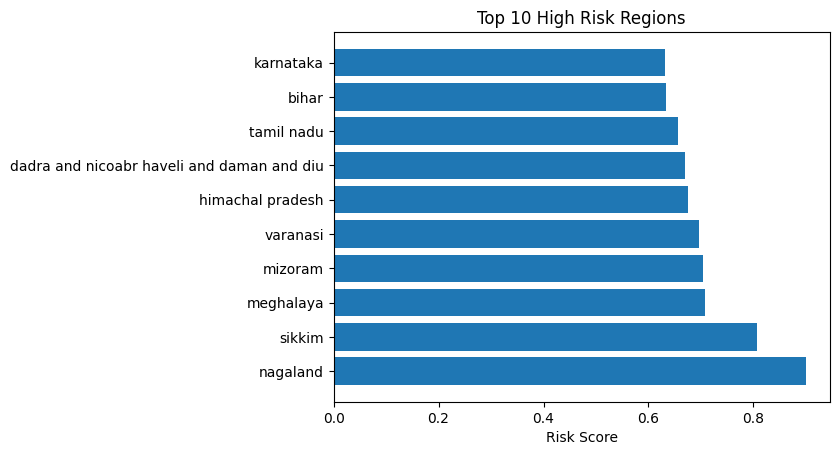

In [30]:
# Top 10 high risk regions
top10 = final_df.sort_values('risk_score', ascending=False).head(10)
plt.barh(top10['State/UT/City'], top10['risk_score'])
plt.title("Top 10 High Risk Regions")
plt.xlabel("Risk Score")
plt.show()


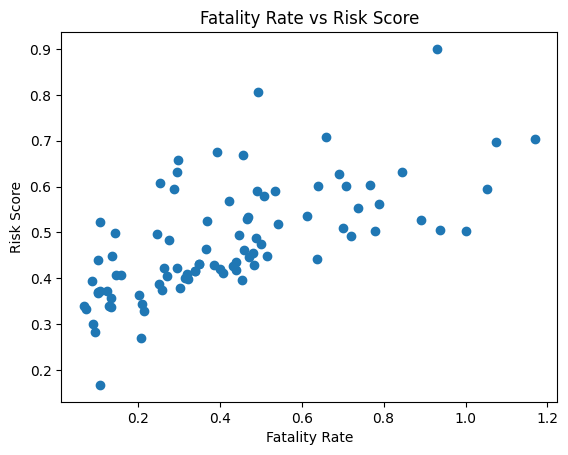

In [29]:
plt.figure()
plt.scatter(final_df['fatality_rate'], final_df['risk_score'])
plt.xlabel("Fatality Rate")
plt.ylabel("Risk Score")
plt.title("Fatality Rate vs Risk Score")
plt.show()


# **SAVE THE FINAL FILE**

In [26]:
final_df.to_csv("accident_map_ready.csv", index=False)
print("Saved as accident_map_ready.csv")

Saved as accident_map_ready.csv
